In [1]:
%load_ext pycodestyle_magic
%flake8_on --ignore=E402,W291,W293 --max_line_length 120

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import requests
from urllib.parse import urlencode
import ssl
from ipywidgets import interact

pallet_name = "rocket"
my_pallet = sns.color_palette(pallet_name)
sns.set_palette(pallet_name, n_colors=7)

In [3]:
ssl._create_default_https_context = ssl._create_unverified_context
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'


def get_download_url(public_key):
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    return download_url

In [4]:
links = {
    'assessments': 'https://disk.yandex.ru/d/PBW7aUHGuodFDA',
    'courses': 'https://disk.yandex.ru/d/m0Z6QYNT46f9tQ',
    'st_assessment': 'https://disk.yandex.ru/d/lsmdbYB0iM7p3w',
    'st_registration': 'https://yadi.sk/d/Yse4Y6RJqg_WaA',
}

In [ ]:
assessments = pd.read_csv(get_download_url(links['assessments']))
courses = pd.read_csv(get_download_url(links['courses']))
student_assessment = pd.read_csv(get_download_url(links['st_assessment']))
student_registration = pd.read_csv(get_download_url(links['st_registration']))

<a class="anchor" id="0-bullet"></a>
# <font color='#35193e'> Навигация по проекту </font>

* [Знакомство с данными](#1-bullet)
    * [assessments](#1.1-bullet)
    * [courses](#1.2-bullet)
    * [studentAssessment](#1.3-bullet)
    * [studentRegistration](#1.4-bullet)
    <br><br>
    * [Анализ перезачетов](#1.9-bullet)
    * [Анализ регистраций/отмен регистраций](#1.5-bullet)
    * [Структура модулей](#1.6-bullet)
    * [Анализ тестов](#1.7-bullet)
    * [Анализ оценок](#1.8-bullet)
    <br><br>
* [Задача 1. Количество сданных курсов студентами](#2-bullet)
* [Задача 2. Сложность экзаменов](#3-bullet)
* [Задача 3. Средний срок сдачи экзаменов](#4-bullet)
* [Задача 4. Популярность предметов](#5-bullet)
* [Задача 5. Завершаемость курсов](#6-bullet)
* [Задача 6. Адаптированные RFM-кластеры студентов](#7-bullet)

***

 <a class="anchor" id="1-bullet"></a>
# <font color='#35193e'> Знакомство с данными </font>

 <a class="anchor" id="1.1-bullet"></a>
## <font color='#701f57'> assessments </font>

Этот файл содержит информацию об оценках в тесте. Обычно каждый предмет в семестре включает ряд тестов с оценками, за которыми следует заключительный экзаменационный тест (экзамен).

* **code_module** — идентификационный код предмета.

* **code_presentation** — семестр (Идентификационный код).

* **id_assessment** — тест (Идентификационный номер ассессмента).

* **assessment_type** — тип теста. Существуют три типа оценивания: 
    * *TMA* - оценка преподавателя
    * *СМА* - компьютерная оценка 
    * *Exam* - экзамен по курсу

* **date** — информация об окончательной дате сдачи теста. Рассчитывается как количество дней с момента начала семестра. Дата начала семестра имеет номер 0 (ноль).

* **weight** — вес теста в % в оценке за курс. Обычно экзамены рассматриваются отдельно и имеют вес 100%; сумма всех остальных оценок составляет 100%.

In [5]:
assessments.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0
3,AAA,2013J,1755,TMA,166.0,20.0
4,AAA,2013J,1756,TMA,215.0,30.0


### <font color='#971c5b'> Общая информация </font>

In [6]:
assessments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   code_module        206 non-null    object 
 1   code_presentation  206 non-null    object 
 2   id_assessment      206 non-null    int64  
 3   assessment_type    206 non-null    object 
 4   date               195 non-null    float64
 5   weight             206 non-null    float64
dtypes: float64(2), int64(1), object(3)
memory usage: 9.8+ KB


#### Проверим, к каким типам тестов относятся пропуски в дате:  </font>

In [7]:
assessments[assessments.date.isna()].assessment_type.value_counts()

Exam    11
Name: assessment_type, dtype: int64

Видим, что все пропущенные значения даты сдачи относятся к экзаменам. <br> Т.к. обычно экзамен сдается в конце курса, предположим, что окончательная дата теста, приходится на последний день курса.

#### Проверим, всегда ли срок сдачи экзамена не превышает длительность курса: </font>

In [8]:
check_day = courses \
    .merge(assessments, on=['code_module', 'code_presentation']) \
    .query("assessment_type == 'Exam' and not date.isna()")

# Разница между датой сдачи курса и длительностью курса
check_day['diff_date'] = check_day.date - check_day.module_presentation_length


print('Максимальное количество дней от окончания курса до окончания экзамена:',
      round(check_day.diff_date.max()),
      'дней')

Максимальное количество дней от окончания курса до окончания экзамена: 0 дней


Теория о том, что экзамены сдаются не позднее даты окончания курса, подтвердилась. 

#### Заменим пропущенные значения датой завершения курса:

In [9]:
na_date = assessments \
    .merge(courses,
           on=['code_module', 'code_presentation']) \
    .query("date.isna()") \
    .module_presentation_length

assessments.fillna({'date': na_date}, inplace=True)

### <font color='#971c5b'> Количество уникальных значений </font>

In [10]:
assessments.nunique()

code_module            7
code_presentation      4
id_assessment        206
assessment_type        3
date                  78
weight                24
dtype: int64

**id_assessment** - уникальное поле

[<font size = 1> <div style="text-align: right"> [К навигации] </div>  </font>](#0-bullet)

***

##  <font color='#701f57'> courses </font>
<a class="anchor" id="1.2-bullet"></a>

Файл содержит список предметов по семестрам.

* **code_module** — предмет (идентификационный код).

* **code_presentation** — семестр (идентификационный код).

* **module_presentation_length** — продолжительность семестра в днях.

In [11]:
courses.head()

,code_module,code_presentation,module_presentation_length
0,AAA,2013J,268
1,AAA,2014J,269
2,BBB,2013J,268
3,BBB,2014J,262
4,BBB,2013B,240


###  <font color='#971c5b'>  Общая информация </font>

In [12]:
courses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 3 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   code_module                 22 non-null     object
 1   code_presentation           22 non-null     object
 2   module_presentation_length  22 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 656.0+ bytes


###  <font color='#971c5b'> Количество уникальных значений </font>

In [13]:
courses.nunique()

code_module                   7
code_presentation             4
module_presentation_length    7
dtype: int64

Проверим, что связка **code_module** и **code_presentation** уникальной. Должно быть 22 курса.

In [14]:
courses[['code_module', 'code_presentation']].drop_duplicates().shape[0]

22

[<font size = 1> <div style="text-align: right"> [К навигации] </div>  </font>](#0-bullet)

***

##  <font color='#701f57'> studentAssessment </font>
<a class="anchor" id="1.3-bullet"></a>

Этот файл содержит результаты тестов студентов. Если учащийся не отправляет работу на оценку, результат не записывается в таблицу.

* **id_assessment** — тест (идентификационный номер).

* **id_student** — идентификационный номер студента.

* **date_submitted** — дата сдачи теста студентом, измеряемая как количество дней с начала семестра.

* **is_banked** — факт перезачета теста с прошлого семестра (иногда курсы перезачитывают студентам, вернувшимся из академического отпуска).

* **score** — оценка учащегося в этом тесте. Диапазон составляет от 0 до 100. *Оценка ниже 40 неудачная*.

In [15]:
student_assessment.head()

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0
3,1752,32885,26,0,69.0
4,1752,38053,19,0,79.0


###  <font color='#971c5b'> Общая информация </font>

In [16]:
student_assessment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173912 entries, 0 to 173911
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id_assessment   173912 non-null  int64  
 1   id_student      173912 non-null  int64  
 2   date_submitted  173912 non-null  int64  
 3   is_banked       173912 non-null  int64  
 4   score           173739 non-null  float64
dtypes: float64(1), int64(4)
memory usage: 6.6 MB


Заполним пропущенные score нулями, т.к. эти студенты не отправили работу на оценку

In [17]:
student_assessment.fillna(0, inplace=True)

###  <font color='#971c5b'> Количество уникальных значений </font>

In [18]:
student_assessment.nunique()

id_assessment       188
id_student        23369
date_submitted      312
is_banked             2
score               101
dtype: int64

Проверим, что связка **id_assessment** и **id_student** является уникальной. Должно быть 173912 результата теста.

In [19]:
student_assessment[['id_assessment', 'id_student']].drop_duplicates().shape[0]

173912

Из этого можно сделать вывод, что 1 студент сдает тест только 1 раз.

###  <font color='#971c5b'> Распределение даты сдачи теста </font>

#### Посмотрим, как распределена дата сдачи не перезачетненных тестов

Диапазон сдачи курсов от -11 до 608 дней


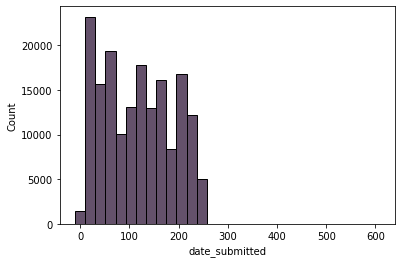

In [20]:
not_banked = student_assessment.query('is_banked == 0')

sns.histplot(data=not_banked, x='date_submitted', bins=30)
print('Диапазон сдачи курсов от',
      not_banked.date_submitted.min(), 'до',
      not_banked.date_submitted.max(), 'дней')

Заменим отрицательные значения на 0 день сдачи (т.к. начать сдавать курс можно только с 0 дня, кроме случаев перезачета)

In [21]:
student_assessment['date_submitted'] = student_assessment \
    .apply(lambda x: x.date_submitted
           if (x.is_banked == 1) | (x.date_submitted >= 0)
           else 0,
           axis=1)

#### Посмотрим дату сдачи относительно длительности курса

Диапазон сдачи курсов от 0.0  до 247.5 % от длительности курса
После завершения курса, тесты сдавали 85 раз


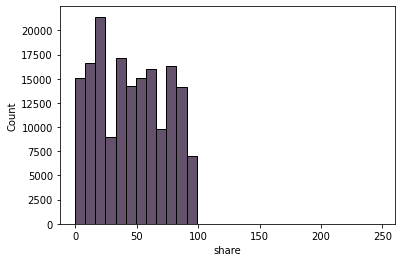

In [22]:
duration = student_assessment \
    .query('is_banked == 0') \
    .merge(assessments, on='id_assessment', how='left') \
    .merge(courses, on=['code_module', 'code_presentation'], how='left')
duration['share'] = round(duration.date_submitted / duration.module_presentation_length * 100, 2)

sns.histplot(data=duration, x='share', bins=30)
print('Диапазон сдачи курсов от', duration.share.min(),
      ' до', duration.share.max(), '% от длительности курса')
print('После завершения курса, тесты сдавали',
      duration.query('share > 100').date_submitted.count(),
      'раз')

#### Посмотрим какой тип теста обычно сдают после окончания курса

In [23]:
duration \
    .query('share > 100') \
    .groupby('assessment_type') \
    .agg({'share': ['count', 'mean']})

share            
                count        mean
assessment_type                  
CMA                70  191.070000
Exam               12  102.800833
TMA                 3  104.136667

Видим, что чаще всего это тесты, проверяемые компьютером. Что имеет место быть, т.к. для проверки не требуется участие преподавателя.

По экзаменам и тестам, проверяемым преподавателем время просрочки не такое большое и таких случаев не так много. Что тоже имеет место быть, т.к. преподаватель мог пойти на встречу некоторым студентам.

Проведенный анализ показывает, что это не похоже на ошибку и править эти случаи не надо.

[<font size = 1> <div style="text-align: right"> [К навигации] </div>  </font>](#0-bullet)

***

##  <font color='#701f57'> studentRegistration </font>
<a class="anchor" id="1.4-bullet"></a>

Этот файл содержит информацию о времени, когда студент зарегистрировался для прохождения курса в семестре.

* **code_module** — предмет (идентификационный код).

* **code_presentation** — семестр (идентификационный код)

* **id_student** — идентификационный номер студента.

* **date_registration** — дата регистрации студента. Это количество дней, измеренное от начала семестра (например, отрицательное значение -30 означает, что студент зарегистрировался на прохождение курса за 30 дней до его начала).

* **date_unregistration** — дата отмены регистрации студента с предмета. У студентов, окончивших курс, это поле остается пустым.

In [24]:
student_registration.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA,2013J,11391,-159.0,NaN
1,AAA,2013J,28400,-53.0,NaN
2,AAA,2013J,30268,-92.0,12.0
3,AAA,2013J,31604,-52.0,NaN
4,AAA,2013J,32885,-176.0,NaN


###  <font color='#971c5b'> Общая информация </font>

In [25]:
student_registration.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   code_module          32593 non-null  object 
 1   code_presentation    32593 non-null  object 
 2   id_student           32593 non-null  int64  
 3   date_registration    32548 non-null  float64
 4   date_unregistration  10072 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 1.2+ MB


###  <font color='#971c5b'> Количество уникальных значений </font>

In [26]:
student_registration.nunique()

code_module                7
code_presentation          4
id_student             28785
date_registration        332
date_unregistration      416
dtype: int64

Проверим, что связка **code_module**, **code_presentation** и **id_student** является уникальной. Должно быть 32593 регистраций.

In [27]:
student_registration[['code_module', 'code_presentation', 'id_student']] \
    .drop_duplicates() \
    .shape[0]

32593

##  <font color='#701f57'> Анализ перезачетов </font>
<a class="anchor" id="1.9-bullet"></a>

Добавим к тестам, которые сдавали студенты, информацию о тесте и информацию о регистрации на курс

In [28]:
student_test = student_assessment \
    .merge(assessments, on='id_assessment') \
    .merge(student_registration,
           on=['code_module', 'code_presentation', 'id_student'],
           how='left')

# Посчитаем, какой итоговый балл получает студент за тест
student_test['weight_score'] = student_test.score * student_test.weight / 100
student_test['is_exam'] = student_test.assessment_type == 'Exam'

###  <font color='#971c5b'> Какие типы тестов чаще всего перезачитывают </font>

In [29]:
student_test[['is_banked', 'assessment_type']].value_counts()

is_banked  assessment_type
0          TMA                97088
           CMA                69956
           Exam                4959
1          TMA                 1338
           CMA                  571
dtype: int64

Можем сделать вывод, что перезачет не распространяется на Экзамены.

###  <font color='#971c5b'> Отметим семестры, которые студенту перезачли </font>


In [30]:
# Выделим студентов и семестры в которых им перезачли тесты
banked = student_test \
    .query("is_banked == 1") \
    .groupby(['id_student', 'code_module', 'code_presentation'],
             as_index=False) \
    .agg({'is_banked': 'mean'})

# Посмотрим в каких семестрах переносят тесты
banked.code_presentation.value_counts()

2014J    227
2013J    151
2014B    116
2013B     32
Name: code_presentation, dtype: int64

Т.к. у нас данные с 2013 голда с семестра B, то мы не сможем. понять с какого семестра были перенесены тесты, следовательно не сможем понять, сколько времени заняла сдача курса (для 32 студентов в семестре 2013B)

#### Выделим семестры из которых был осуществлен перенос

In [31]:
# Отметим все семестры, когда студент сдавал тесты.
# Отметим те семестры, где был перезачет и дату сдачи последнего теста
student_courses = student_test \
    .groupby(['id_student', 'code_module', 'code_presentation'],
             as_index=False) \
    .agg({'is_banked': 'sum',
          'date_submitted': 'max'}) \
    .rename(columns={'date_submitted': 'last_date'})

student_courses['is_banked'] = student_courses['is_banked'] > 0

# Отметим модули, где был хотя бы один перезачет
student_courses = student_courses.merge(banked,
                                        on=['id_student', 'code_module'],
                                        how='left')

# Посмотрим с какого семестра была перенесена оценка
student_courses['moved'] = (student_courses.code_presentation_y > student_courses.code_presentation_x)
student_courses['moved'] = student_courses['moved'] * (~student_courses.is_banked_y.isna())

columns = ['id_student', 'code_module',
           'code_presentation_x',
           'is_banked_x',
           'moved',
           'last_date']
student_courses = student_courses[columns] \
    .copy() \
    .rename(columns={'code_presentation_x': 'code_presentation',
                     'is_banked_x': 'is_banked'})

student_courses.head()

,id_student,code_module,code_presentation,is_banked,moved,last_date
0,6516,AAA,2014J,False,False,210.0
1,8462,DDD,2013J,False,True,85.0
2,8462,DDD,2014J,True,False,-1.0
3,11391,AAA,2013J,False,False,212.0
4,23629,BBB,2013B,False,False,95.0


[<font size = 1> <div style="text-align: right"> [К навигации] </div>  </font>](#0-bullet)

***

##   <font color='#701f57'> Анализ регистраций и отмен регистраций </font>
<a class="anchor" id="1.5-bullet"></a>

###  <font color='#971c5b'> Nan в дате регистрации </font>

Посмотрим, сдавали ли тесты студенты по тем курсам, где у них пропущено поле регистрации

In [32]:
# Посмотрим среднюю оценку за курс
# без учета перезачетов и тестов сданных не в срок
ttl_score = student_test \
    .query("is_banked == 0 & date_submitted <= date") \
    .groupby(['id_student', 'code_module', 'code_presentation'],
             as_index=False) \
    .agg({'score': 'mean',
          'id_assessment': 'count',
          'date_submitted': 'max'}) \
    .rename(columns={'id_assessment': 'num_test',
                     'date_submitted': 'last_submitted'})

# Добавим полученную информацию к регистрационным данным
not_registration = student_registration \
    .query("date_registration.isna()") \
    .merge(ttl_score,
           how='left',
           on=['id_student', 'code_module', 'code_presentation'])

In [33]:
# Выберем те предметы, по которым не было отмены регистрации
not_registration.query("date_unregistration.isna()")

,code_module,code_presentation,id_student,date_registration,date_unregistration,score,num_test,last_submitted
0,BBB,2013B,630346,NaN,NaN,NaN,NaN,NaN
16,CCC,2014J,1777834,NaN,NaN,NaN,NaN,NaN
19,DDD,2013B,2707979,NaN,NaN,NaN,NaN,NaN
20,DDD,2013B,2710343,NaN,NaN,NaN,NaN,NaN
28,DDD,2014B,2710343,NaN,NaN,NaN,NaN,NaN
35,FFF,2013B,2102658,NaN,NaN,NaN,NaN,NaN


Видим, что по этим предметам студенты не сдавали тесты. Значит можно удалить из таблицы

In [34]:
drop_el = student_registration.date_registration.isna() & student_registration.date_unregistration.isna()
student_registration.drop(np.where(drop_el)[0], inplace=True)

Для остальных поставим дату регистрации на курс минимальной (**-365**), чтоб выделять такие кейсы в отдельную группу.

In [35]:
student_registration['date_registration'] = student_registration['date_registration'].fillna(-365)

### <font color='#971c5b'> Отмена регистрации до сдачи последнего теста </font>

Отмета регистрации должна происходить не раньше последнего сданного теста по предмету.

In [36]:
erlier_unreg = student_registration \
    .merge(ttl_score,
           on=['id_student', 'code_module', 'code_presentation']) \
    .query("last_submitted > date_unregistration") \
    .sort_values('num_test')

erlier_unreg['diff_day'] = erlier_unreg.last_submitted - erlier_unreg.date_unregistration
print(erlier_unreg.shape[0])
erlier_unreg.sort_values('diff_day', ascending=False).head()

221


,code_module,code_presentation,id_student,date_registration,date_unregistration,score,num_test,last_submitted,diff_day
14369,EEE,2013J,2681277,-365.0,-166.0,94.000000,1,32.0,198.0
20403,FFF,2014J,560459,-10.0,12.0,38.500000,2,157.0,145.0
20229,FFF,2014J,408499,-31.0,94.0,87.333333,3,236.0,142.0
18624,FFF,2013J,608111,-30.0,93.0,75.333333,3,208.0,115.0
16447,FFF,2013B,533874,-22.0,27.0,34.000000,5,131.0,104.0


Видим, что отмена регистрайции для 221 студента поизошла раньше, чем последняя попытка сдачи теста по курсу. Это говорит о том, что дата отмены регистрации не говорит, о том, что студент в этот день перестал проходить курс.

Посмотрим, скролько дней для таких студентов прошло от отмены регистрации до последнего сданного теста:

<AxesSubplot:xlabel='diff_day', ylabel='Count'>

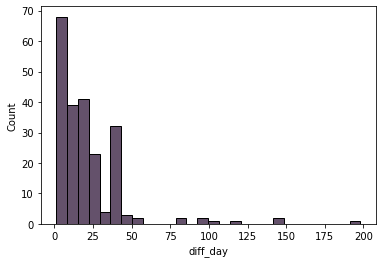

In [37]:
sns.histplot(erlier_unreg.diff_day)

Для большинства из таких студентов отмена регистрации происходила за 1-2 месяца до последней сдачи теста

###  <font color='#971c5b'> Отмена регистраций раньше регистрации </font>

Убедимся, что не было отмен регистраций до самой регистрации:

In [38]:
student_registration[student_registration.date_unregistration < student_registration.date_registration]

,code_module,code_presentation,id_student,date_registration,date_unregistration


###  <font color='#971c5b'> Отмены регистраций до начала курса </font>

Посмотрим, сколько случаев, когда регистрацию отменили до начала курса.

In [39]:
print(student_registration[student_registration.date_unregistration < 0].shape[0],
      'отмен регистрации еще до начала курса')

2678 отмен регистрации еще до начала курса


При дальнейшем анализе популярности курсов (колиечество регистраций), стоит выделять студентов, которые отменили регистрацию до начала семестра в отдельную группу, **т.к. они передумали проходить курс еще до его начала**

[<font size = 1> <div style="text-align: right"> [К навигации] </div>  </font>](#0-bullet)

***

##  <font color='#701f57'> Структура модулей </font>
<a class="anchor" id="1.6-bullet"></a>

Для начала посмотрим,что из себя представляет *code_presentation*

In [40]:
print(*assessments.code_presentation.unique())

2013J 2014J 2013B 2014B


Можно сделать преположение, что *code_presentation* состоит из года (2013, 2014) и семестра (J, B).

Выделим отдельно год (**year**) и семестр (**presentation**)

In [41]:
assessments['year'] = assessments.apply(lambda x: x.code_presentation[:4], axis=1).astype('int')
assessments['presentation'] = assessments.apply(lambda x: x.code_presentation[-1], axis=1)

#### Посмотрим на структуру разных модулей:

In [42]:
course_struct = assessments \
    .groupby(['code_module', 'code_presentation', 'assessment_type'], as_index=False) \
    .agg({'id_assessment': 'count',
          'weight': 'sum'}) \
    .rename(columns={'id_assessment': 'num_test'}) \
    .sort_values(by='assessment_type', key=lambda col: col == 'Exam')

In [43]:
@interact(module=assessments.code_module.unique())
def course_struct_plt(module):
    def plt_pie(x, y, **kwargs):
        def func(pct, allvals):
            absolute = int(pct / 100. * np.sum(allvals))
            return f'{absolute}'
        plt.pie(y,
                labels=x,
                colors=my_pallet[-3:],
                autopct=lambda pct: func(pct, y))
    
    module_struct = course_struct[course_struct.code_module == module]
    
    g = sns.FacetGrid(module_struct, col="code_presentation", sharey=False, height=3)
    g = (g.map(plt_pie, "assessment_type", "num_test"))
    g.set_titles(col_template="{col_name}")
    g.fig.suptitle(module)
    
    g = sns.FacetGrid(module_struct, col="code_presentation", sharey=False, height=3)
    g = (g.map(plt_pie, "assessment_type", "weight"))
    g.set_titles(col_template="{col_name}")

interactive(children=(Dropdown(description='module', options=('AAA', 'BBB', 'CCC', 'DDD', 'EEE', 'FFF', 'GGG')…

In [7]:
# def plt_pie(x, y, **kwargs):
#     def func(pct, allvals):
#         absolute = int(pct / 100. * np.sum(allvals))
#         return f'{absolute}'
#     plt.pie(y, labels=x, colors=my_pallet[-3:], autopct=lambda pct: func(pct, y))
#     ax = plt.gca ()
#     plt.axis('off')


# course_struct.sort_values(['code_presentation', 'code_module'], inplace=True)
# g = sns.FacetGrid(course_struct, col='code_presentation', row='code_module', height=3)
# g = (g.map(plt_pie, 'assessment_type', 'num_test'))
# g.set_titles(col_template='{col_name}')
# g.fig.suptitle(module)

# plt.show()

#### Разберем помодульно структуру семестра:
    
* **AAA** - В сесместре **B** данный модуль не преподается, в семестре **J** в оба года имел одинаковую структуру.

    
* **BBB** - Преподавался в каждом семестре, но в семестре **J** в 2014 году структура немного изменилась.

*На данном этапе можно сделать вывод, что семестр **B** идет раньше по времени, чем **J**.*


* **CCC** -  Преподавался с 2014 года и во всех семестрах имеет одинаковую структуру.
    
*Стоит отметить, что в структуре модуля присутсвует 2 экзамена с общим весом 200%, что противоречит описанию таблицы.*
    
* **DDD** - Поменял структуру с семестра **J** 2013 года.
    
*Тут можем подтвердить теорию о том, что семестр **B** идет раньше по времени, чем **J**.*
    
    
* **EEE**, **GGG** - Преподавались с семестра **J** 2013 года и во всех семестрах имели одинаковую структуру.
    
    
* **FFF** - Во всех семестрах имели одинаковую структуру.

*Стоит отметить, что в структуре модуля GGG все тесты, кроме экзамена имеют вес 0*

#### Note:

Из приведенного выше разбора **на данном этапе** можно сделать следующие выводы:
* курс читается 2 раза в год (т.е. курсом можно считать модуль)
* семестр **B** идет в году раньше семестра **J**


Из сделанных выводов напрашивается предположение, что студенту нет смысла сдавать один курс дважды

###   <font color='#971c5b'> Анализ экзаменов модуля ССС </font>

Проверим, сколько экзаменов по модулю **CCC** сдают студенты.

In [45]:
student_test \
    .query("(code_module == 'CCC') and (assessment_type == 'Exam')") \
    .groupby('id_student', as_index=False) \
    .agg({'id_assessment': 'count'}) \
    .id_assessment \
    .value_counts()

1    1915
Name: id_assessment, dtype: int64

In [46]:
student_test \
    .query("(code_module == 'CCC') and (assessment_type == 'Exam')")[['code_presentation', 'id_assessment']] \
    .drop_duplicates()

,code_presentation,id_assessment
52923,2014B,24290
63953,2014J,24299


Видим, что студенты сдают только один экзамен за семестр. Следовательно суммарная оценка за экзамен не превысит 100

###  <font color='#971c5b'> Сколько раз студент сдает модуль </font>

Посмотрим, сколько студентов предприняло попытки повторно пройти курс (без переноса оценок)

In [47]:
student_courses \
    .query('~moved') \
    .groupby(['id_student', 'code_module'], as_index=False) \
    .agg({'code_presentation': 'count'}) \
    .query('code_presentation > 1') \
    .sort_values('code_presentation') \
    .shape[0]

353

### <font color='#971c5b'>  Длительность семестров </font>

<AxesSubplot:xlabel='module_presentation_length', ylabel='Count'>

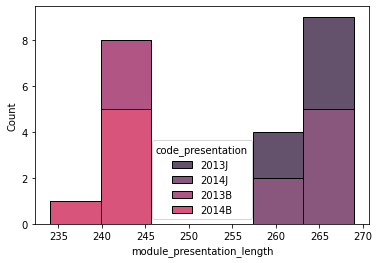

In [48]:
sns.histplot(data=courses,
             x='module_presentation_length',
             hue='code_presentation',
             multiple='stack')

Семестры **J** и **B** отличаются по длительности. Средний срок сдачи лучше рассматривать относительно длительности курса в семестре.

[<font size = 1> <div style="text-align: right"> [К навигации] </div>  </font>](#0-bullet)

***

##  <font color='#701f57'> Анализ тестов </font>
<a class="anchor" id="1.7-bullet"></a>

###  <font color='#971c5b'> Количество попыток сдачи тестов </font>

Посмотрим, сколько раз студенты пытаются сдать тест (т.е. тест в рамках семестра)

In [49]:
student_test \
    .groupby(['id_student', 'id_assessment', 'assessment_type'], as_index=False) \
    .agg({'score': 'count'}) \
    .score \
    .value_counts()

1    173912
Name: score, dtype: int64

У студентов, в рамках одного теста только одна попытка сдачи.

Стоит отметить, что не по всеем тестам были попытки сдачи. Проверим, какие тесты не сдавали студенты

In [50]:
assessments \
    .merge(student_assessment, how='left', on='id_assessment') \
    .query("id_student.isna()")[['assessment_type', 'code_module']] \
    .value_counts()

assessment_type  code_module
Exam             BBB            4
                 FFF            4
                 EEE            3
                 GGG            3
                 AAA            2
                 CCC            2
dtype: int64

Видим, что по некоторым курсам экзамен не сдается. Скорее всего по ним зачет ставится на основании тестов втечении семеста

##   <font color='#701f57'> Анализ оценок </font>
<a class="anchor" id="1.8-bullet"></a>

###  <font color='#971c5b'> Средняя оценка за семестр </font>

Для расчета этого показателя будем использовать количество тестов, которое необходимо было сдать

In [51]:
num_not_exam = course_struct \
    .query("assessment_type != 'Exam'") \
    .groupby(['code_module', 'code_presentation'], as_index=False) \
    .agg({'num_test': 'sum',
          'weight': 'sum'})

In [52]:
tttl_score = student_test \
    .groupby(['id_student', 'code_module', 'code_presentation', 'is_exam'], as_index=False) \
    .agg({'score': 'sum',
          'weight_score': 'sum'}) \
    .merge(num_not_exam,
           on=['code_module', 'code_presentation'],
           how='left') \
    .rename(columns={'score': 'sum_score'}) \
    .sort_values('code_module')

tttl_score['avg_score'] = tttl_score.sum_score / tttl_score.num_test * ~tttl_score.is_exam
tttl_score['avg_score'] = tttl_score['avg_score'] + tttl_score.sum_score * tttl_score.is_exam

#### Посмотрим, как рапспределены средние оценки за семестр по разным модулям

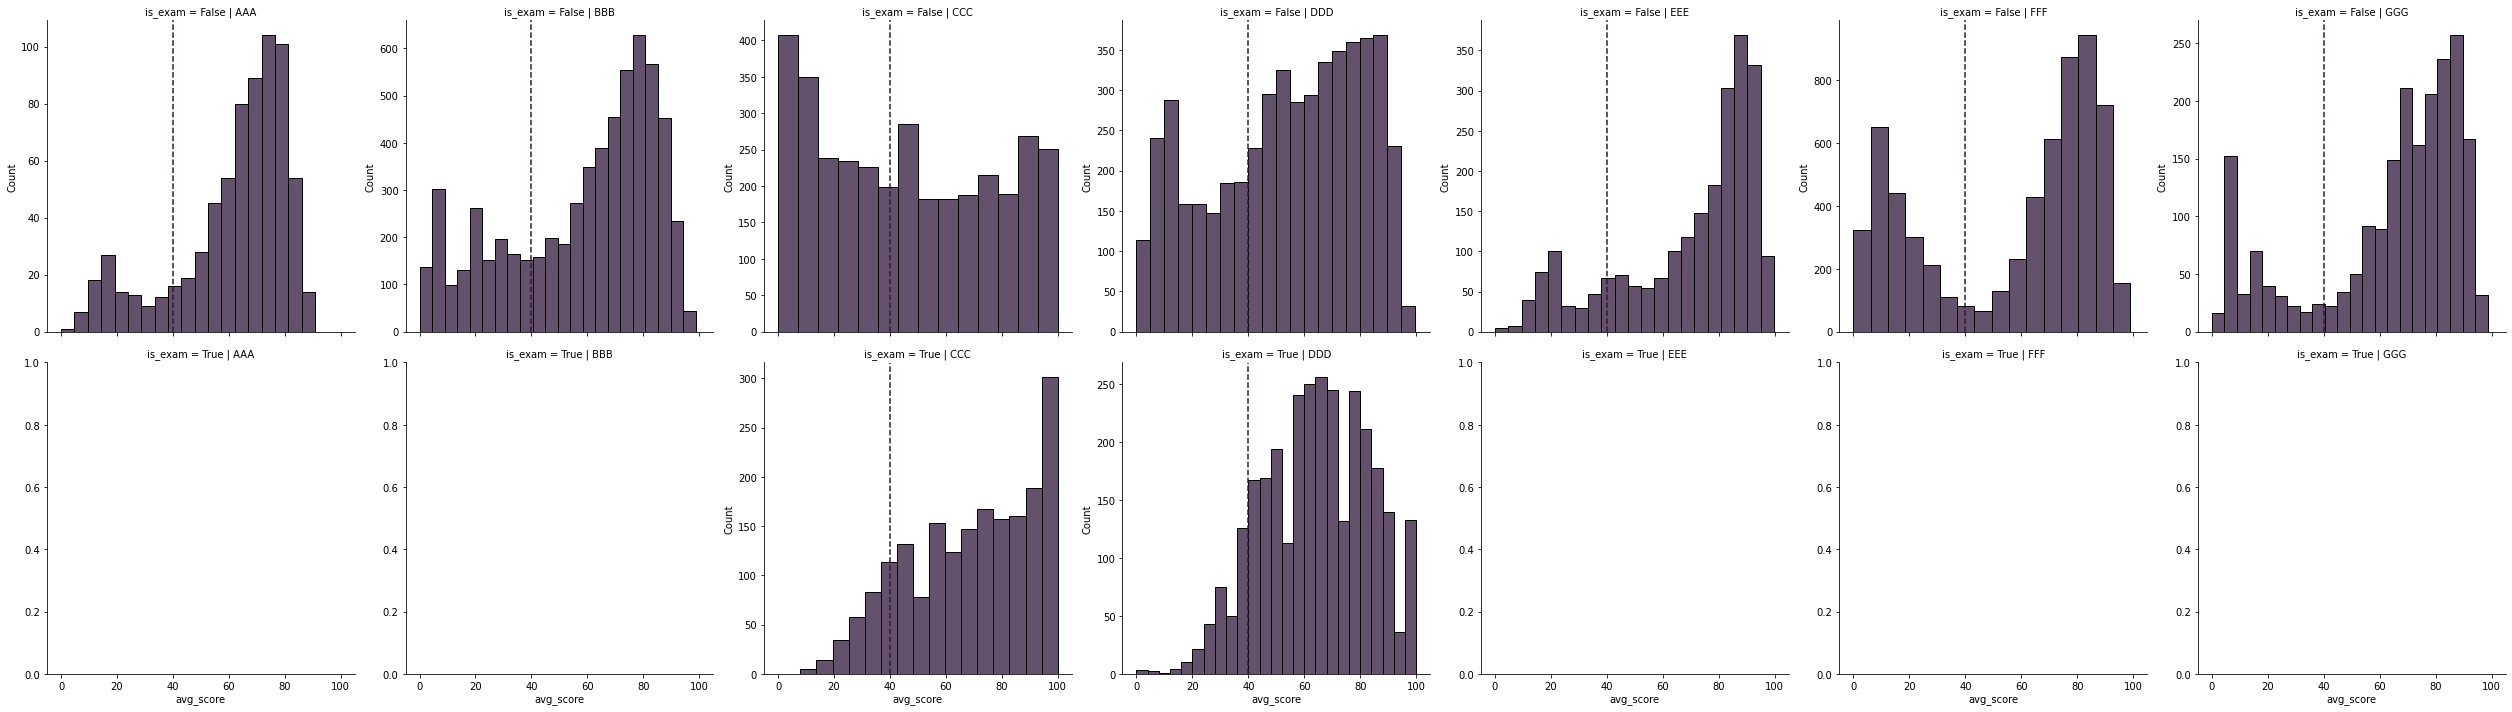

In [53]:
def plt_hist(x, **kwargs):
    sns.histplot(x)
    plt.axvline(x=40, ls='--')


g = sns.FacetGrid(tttl_score, col="code_module", row='is_exam', sharey=False, height=5)
g = (g.map(plt_hist, "avg_score"))
g.set_titles(col_template="{col_name}")

###  <font color='#971c5b'> Взвешенная оценка за семестр </font>

Рассмотрим аналогично предыдущему пункту разделив на экзамен и тесты втечении семестра

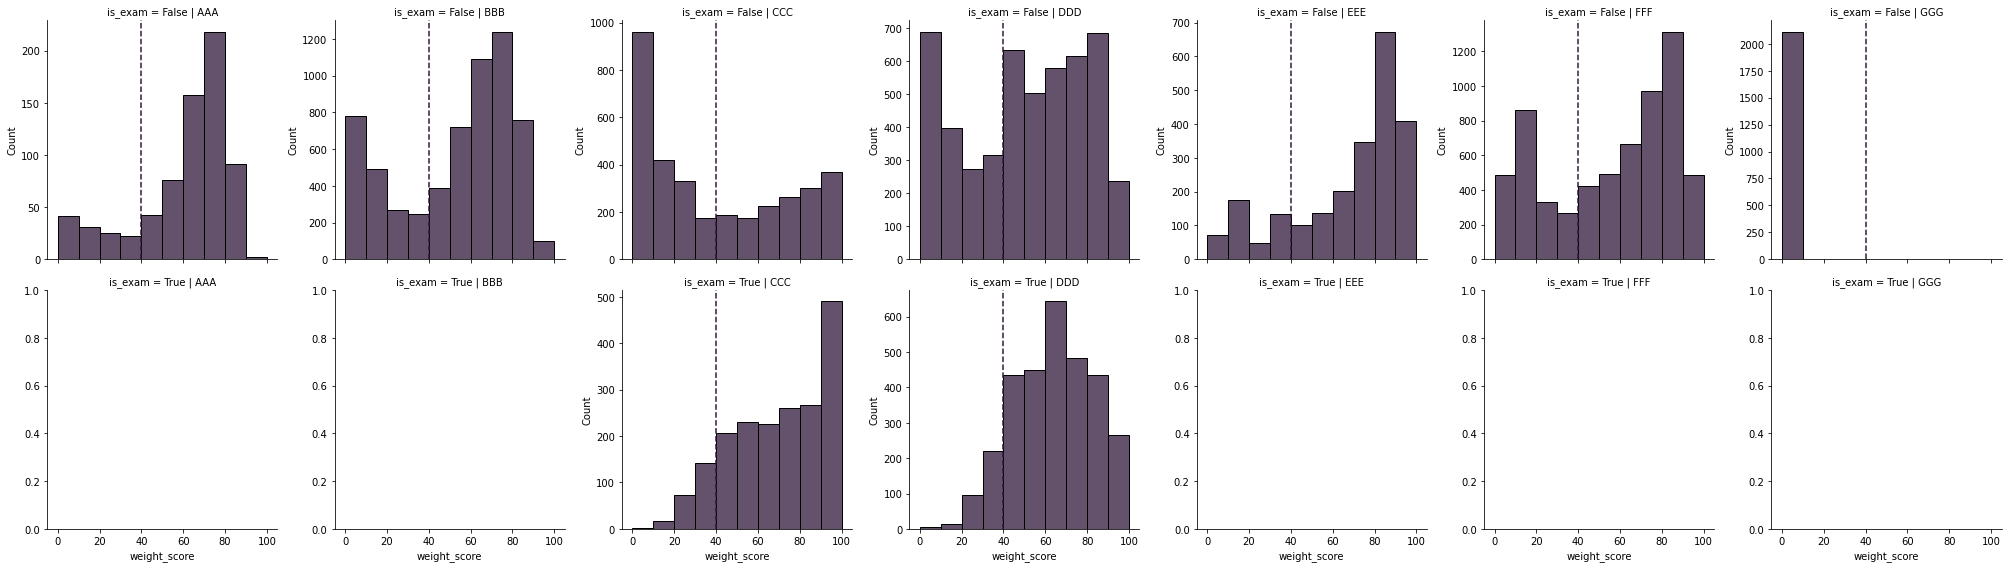

In [54]:
def plt_hist(x, **kwargs):
    sns.histplot(x, binwidth=10, binrange=(0, 100))
    plt.axvline(x=40, ls='--')


g = sns.FacetGrid(tttl_score, col="code_module", row='is_exam', sharey=False, height=4)
g = (g.map(plt_hist, "weight_score"))
g.set_titles(col_template="{col_name}")

###  <font color='#971c5b'> Отметим удачную сдачу курса </font>

На основе проделанного анализа, можно сделать вывод о том, что будем считать зачетом на экзамене:
    
* Если регистрация отменена, то курс не сдан
* Если по модулю сдается экзамен, то оценка по курсу ставится на основании экзамена 
    * **CCC**
    * **DDD**
* Если экзамен не сдается, то оценка выставляется на основании оценки за тесты
    * **AAA**
    * **BBB**
    * **EEE**
    * **FFF**
* Если вес тестов нулевой, то оценка выставляется исходя из среднего балла за тесты
    * **GGG**

In [55]:
# Разобьем score среднюю и взвешанную на Экзамен и Тесты
score_by_type = tttl_score \
    .pivot_table(index=['id_student', 'code_module', 'code_presentation'],
                 columns='is_exam',
                 values=['weight_score', 'avg_score']) \
    .reset_index()

# Добавим эту информацию к семестрам, которые сдавали студенты
student_courses = student_courses \
    .copy() \
    .merge(score_by_type,
           on=['id_student',
               'code_module',
               'code_presentation'],
           how='left') \
    .rename(columns={('avg_score', False): 'avg_score',
                     ('avg_score', True): 'exam',
                     ('weight_score', False): 'test'}) \
    .drop([('weight_score', True)], axis=1) \
    .sort_values('code_module')

/var/folders/wj/3qntsrcn3v36d4nnv9sxbm940000gn/T/ipykernel_5156/2686176621.py:9: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  student_courses = student_courses \
/var/folders/wj/3qntsrcn3v36d4nnv9sxbm940000gn/T/ipykernel_5156/2686176621.py:9: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  student_courses = student_courses \


In [56]:
# По курсам выделим показатель, по которому будем считать оценку за курс
type_exam = {
    'AAA': 'test',
    'BBB': 'test',
    'CCC': 'exam',
    'DDD': 'exam',
    'EEE': 'test',
    'FFF': 'test',
    'GGG': 'avg_score'
}

student_courses = student_courses \
    .merge(student_registration[['id_student',
                                 'code_module',
                                 'code_presentation',
                                 'date_unregistration']],
           on=['id_student', 'code_module', 'code_presentation'])

# Найдет итоговую оценку за курс и выделим сдан ли курс
student_courses['course_score'] = student_courses.apply(lambda x: x[type_exam[x.code_module]], axis=1)
student_courses['is_pass'] = (student_courses.course_score >= 40) & student_courses.date_unregistration.isna()

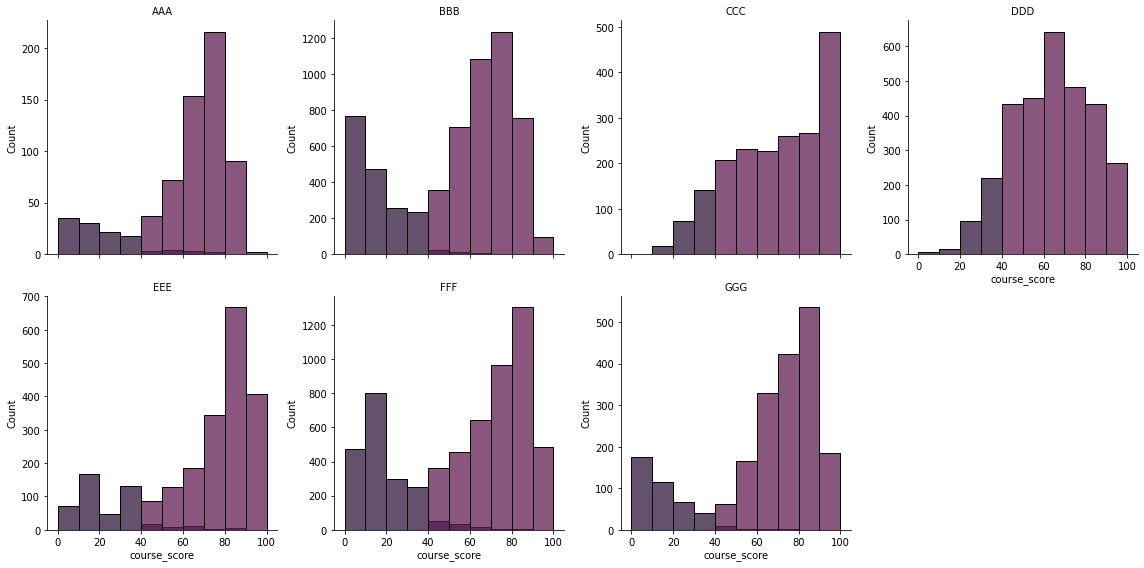

In [57]:
g = sns.FacetGrid(student_courses[~student_courses.moved], 
                  col="code_module", 
                  hue="is_pass", 
                  sharey=False, 
                  height=4, 
                  col_wrap=4)

g = (g.map(sns.histplot, "course_score", binwidth=10, binrange=(0, 100)))
g.set_titles(col_template="{col_name}")

###  <font color='#971c5b'> Отметим попытку сдачи экзамена </font>

На основе предыдущего вывода, попытка сдачи экзамена:

* Для курсов **CCC**, **DDD** - это наличие оценки по экзамену
* Для остальных курсов - это сдача хотя бы одного теста по курсу
    
**Note:**

Исходя из задания, что:
    
    завершаемость = кол-во успешных экзаменов / кол-во всех попыток сдать экзамен
    
следует, что студенты, которые отменили курс не должны попадать в значенатель, т.к. они и не пытались сдать курс.
   
    
   Но в этом случае хромает логика о том, что они все таки пытались пройти этот курс и не смогли (не завершили), что в свою очередь и несет в себе понятие завершаемости.
    
    
Мною было принято решение в рамках проекта оставить таких студентов в статистике курса, но на реальной практике я бы обсудила этот вопрос с заказчиком, для правильного понимания поставленной задачи

In [58]:
student_courses['is_attempt'] = student_courses.apply(lambda x: ~np.isnan(x.exam)
                                                      if x.code_module in ['CCC', 'DDD']
                                                      else True,
                                                      axis=1)
# student_courses['is_attempt'] = student_courses.is_attempt * student_courses.date_unregistration.isna()

[<font size = 1> <div style="text-align: right"> [К навигации] </div>  </font>](#0-bullet)

***

#  <font color='#35193e'> Задача 1. Количество сданных курсов студентами </font>
<a class="anchor" id="2-bullet"></a>

Сколько студентов успешно сдали только один курс? 

**Успешная сдача — это зачёт по курсу на экзамене**

#### Note:

* Под курсом будем считать модуль. 
* Если студет сдавал один курс дважды, то за результат будем брать последнюю успешную попытку сдачи курса.
* Зачетом по экзамену будем считать **(score >= 40)**:
    * По экзамену, если он проводится по курсу
    * По тестам в семестре, если экзамен не проводится по курсу
    * Среднюю оценку за тесты в семестре, если у них нет веса

In [59]:
# Выберем только успешные поптыки сдать экзамен по курсу и среди них возьмем последний
student_exam_last = student_courses \
    .query('is_pass') \
    .sort_values('code_presentation') \
    .groupby(['id_student', 'code_module'], as_index=False) \
    .tail(1)

# Найдем сколько курсов сдал каждый студент 
number_of_exams = student_exam_last \
    .groupby('id_student', as_index=False) \
    .agg({'code_module': 'count'}) \
    .rename(columns={'code_module': 'num_pass'}) \
    .sort_values('num_pass', ascending=False)

number_of_exams.num_pass.value_counts()

1    15268
2      820
3        2
Name: num_pass, dtype: int64

In [60]:
print(number_of_exams.num_pass.value_counts()[1], 'студентов успешно сдали только один курс')

15268 студентов успешно сдали только один курс


[<font size = 1> <div style="text-align: right"> [К навигации] </div>  </font>](#0-bullet)

***

# <font color='#35193e'>  Задача 2. Сложность экзаменов </font>
<a class="anchor" id="3-bullet"></a>

Выяви самый сложный и самый простой экзамен: найди курсы и экзамены в рамках курса, которые обладают самой низкой и самой высокой завершаемостью

**завершаемость = кол-во успешных экзаменов / кол-во всех попыток сдать экзамен**

In [61]:
exam_statistics = student_courses \
    .groupby(['code_module', 'code_presentation'], as_index=False) \
    .agg({'is_pass': 'sum', 
          'is_attempt': 'count'}) \
    .rename(columns={'is_attempt': 'num_attempt', 
                     'is_pass': 'num_pass'}) 

exam_statistics['completion'] = (exam_statistics.num_pass / exam_statistics.num_attempt * 100).round(2)
exam_statistics = exam_statistics.sort_values('completion', ascending=False)

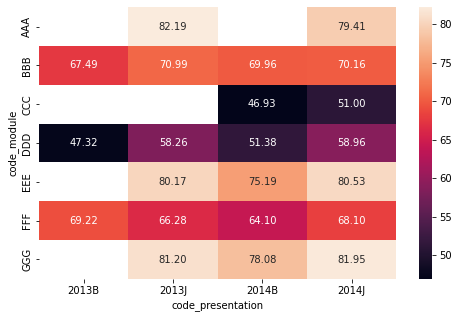

In [62]:
plt.figure(figsize=(8, 5))
compl = exam_statistics.pivot("code_module", "code_presentation", "completion")
sns.heatmap(compl, annot=True, fmt=".2f")
plt.show()

In [63]:
def print_result(element, name):
    print(f'Самый {name} экзамен',
          f'в рамках курса \033[1m{element.code_module}\033[0m',
          f'в \033[1m{element.code_presentation[:4]}\033[0m году',
          f'в семестре \033[1m{element.code_presentation[-1]}\033[0m',
          f'его завершаемость составляет \033[1m{element.completion}\033[0m%')


print_result(exam_statistics.iloc[-1], 'сложный')
print_result(exam_statistics.iloc[0], 'простой')

Самый сложный экзамен в рамках курса CCC в 2014 году в семестре B его завершаемость составляет 46.93%
Самый простой экзамен в рамках курса AAA в 2013 году в семестре J его завершаемость составляет 82.19%


#### Посмотрим аналогичную информацию исключив студентов, которые не пытались сдать экзамены по предметам CCC и DDD

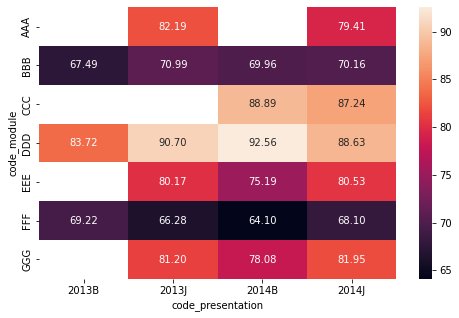

In [64]:
exam_statistics = student_courses \
    .groupby(['code_module', 'code_presentation'], as_index=False) \
    .agg({'is_pass': 'sum', 
          'is_attempt': 'sum'}) \
    .rename(columns={'is_attempt': 'num_attempt', 
                     'is_pass': 'num_pass'}) 

exam_statistics['completion'] = (exam_statistics.num_pass / exam_statistics.num_attempt * 100).round(2)
exam_statistics = exam_statistics.sort_values('completion', ascending=False)

plt.figure(figsize=(8, 5))
compl = exam_statistics.pivot("code_module", "code_presentation", "completion")
sns.heatmap(compl, annot=True, fmt=".2f")
plt.show()

Видим, что для предметов CCC и DDD завершаемость стала значительно выше, т.к. много студентов даже не дошли до сдачи итогового экзамена. Что говорит о сложности этих курсов. Но если ты смог дойти до экзамена, то его ты сдаешь хорошо.

[<font size = 1> <div style="text-align: right"> [К навигации] </div>  </font>](#0-bullet)

***

#  <font color='#35193e'> Задача 3. Средний срок сдачи экзаменов </font>
<a class="anchor" id="4-bullet"></a>

По каждому предмету определи средний срок сдачи экзаменов 

*Под сдачей понимаем последнее **успешное** прохождение экзамена студентом*

* В рамках одного теста, у студента только одна попытка его сдачи
* В рамках курса, будем учитывать экзамен только последнего успешно сданного семестра
* Для курсов, где зачет по экзамену выставляется на основе тестов в курсе, будеми учитывать дату последнего теста
* Исключим тех студентов, у которых последний тест по перезачету (last_date = -1)

**Note:**

Т.к. семестры **B** и **J** разные по длительности, помимо абсолютного значения посмотрим еще и относительное, чтоб сравнение было более корректное

In [65]:
student_courses = student_courses \
    .merge(courses, on=['code_module', 'code_presentation'], how='left')
student_courses['share'] = round(student_courses.last_date / student_courses.module_presentation_length * 100, 2)

In [66]:
def round_mean(x):
    return round(x.mean(), 2)


duration = student_courses \
    .query('last_date > 0 & is_pass') \
    .sort_values('code_presentation') \
    .groupby(['id_student', 'code_module']) \
    .tail(1) \
    .merge(courses, 
           on=['code_module', 'code_presentation'],
           how='left')

avg_duration_module = duration \
    .groupby('code_module', as_index=False) \
    .agg({'last_date': round_mean, 'share': round_mean})

avg_duration_module.sort_values('share')

,code_module,last_date,share
4,EEE,157.70,60.14
1,BBB,198.54,78.48
0,AAA,214.30,79.82
5,FFF,212.73,82.86
6,GGG,216.10,84.21
2,CCC,239.35,92.92
3,DDD,237.98,93.84


[<font size = 1> <div style="text-align: right"> [К навигации] </div>  </font>](#0-bullet)

***

#  <font color='#35193e'> Задача 4. Популярность предметов </font>
<a class="anchor" id="5-bullet"></a>

 Выяви самые популярные предметы (ТОП-3) по количеству регистраций на них. <br>
 А также предметы с самым большим оттоком (ТОП-3)
 
 * Студентов, отменивших регистрацию до начала курса, выделим в отдельную группу
 * Если студент зарегистрировался на курс несколько раз (в разных семестрах), то будем считать это как одну регистрацию (т.к. популярность – это охват аудитории)
 * Если студент зарегистрировался на курс несколько раз, отмену регистрации будем считать только если он отменил регистрацию во всех семестрах
 * Оттоком будем считать отношение отмен регистраций к общему количеству регистраций

In [67]:
# Среди регистраций на курс у студента выберем ту, у которой дата отмены максимальная (или Nan, если ее не было)
best_registration = student_registration \
    .sort_values('date_unregistration') \
    .groupby(['id_student', 'code_module'], as_index=False) \
    .tail(1)

In [68]:
def unregistration(x):
    return (~x.isna()).sum()


ttl_registration = best_registration \
    .groupby('code_module', as_index=False) \
    .agg({'id_student': 'count',
          'date_unregistration': unregistration}) \
    .rename(columns={'id_student': 'registration',
                     'date_unregistration': 'unregistration'}) \
    .sort_values('registration', ascending=False)

print("TOP-3 самых популярных курса по количеству регистраций")
ttl_registration[['code_module', 'registration']][:3]

TOP-3 самых популярных курса по количеству регистраций


,code_module,registration
1,BBB,7691
5,FFF,7396
3,DDD,5846


Посмотрим ТОП-3 курсов без учета студентов, которые отменили регистрацию до начала курса

In [69]:
ttl_started = best_registration \
    .query('~(date_unregistration < 0)') \
    .groupby('code_module', as_index=False) \
    .agg({'id_student': 'count', 
          'date_unregistration': unregistration}) \
    .rename(columns={'id_student': 'registration', 
                     'date_unregistration': 'unregistration'}) \
    .sort_values('registration', ascending=False)

print("TOP-3 самых популярных курса по количеству начавших обучение")
ttl_started[['code_module', 'registration']][:3]

TOP-3 самых популярных курса по количеству начавших обучение


,code_module,registration
5,FFF,6894
1,BBB,6887
3,DDD,5417


Посмотрим через сколько после начала курса отменяют регистрацию

In [70]:
best_registration = best_registration \
    .merge(courses, on=['code_module', 'code_presentation'], how='left')

In [71]:
best_registration['category'] = best_registration \
    .apply(lambda x: min((x.date_unregistration * 100 / x.module_presentation_length) // 10, 9)
           if ((x.date_unregistration >= 0) | np.isnan(x.date_unregistration))
           else -2, 
           axis=1)

best_registration['category'] = (best_registration['category'] + 1) * 10

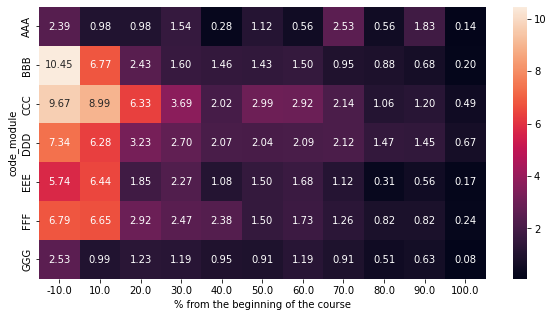

In [72]:
category = best_registration \
    .groupby(['code_module', 'category'], as_index=False) \
    .agg({'id_student': 'count'}) \
    .merge(ttl_registration, on='code_module', how='left')
category['churn_rate'] = round(category.id_student / category.registration * 100, 2)

plt.figure(figsize=(10, 5))
unreg = category.pivot("code_module", "category", "churn_rate")
sns.heatmap(unreg, annot=True, fmt=".2f")
plt.xlabel('% from the beginning of the course')
plt.show()

In [73]:
ttl_registration['churn_rate'] = round(ttl_registration.unregistration / ttl_registration.registration * 100, 2)

print("TOP-3 курса с самым большим оттоком среди всех зарегистрировавшихся")
ttl_registration[['code_module', 'churn_rate']].sort_values('churn_rate', ascending=False)[:3]

TOP-3 курса с самым большим оттоком среди всех зарегистрировавшихся


,code_module,churn_rate
2,CCC,41.51
3,DDD,31.46
1,BBB,28.34


In [74]:
ttl_started['churn_rate'] = round(ttl_started.unregistration / ttl_started.registration * 100, 2)

print("TOP-3 курса с самым большим оттоком среди начавших обучение")
ttl_started[['code_module', 'churn_rate']].sort_values('churn_rate', ascending=False)[:3]

TOP-3 курса с самым большим оттоком среди начавших обучение


,code_module,churn_rate
2,CCC,35.24
3,DDD,26.03
5,FFF,22.32


[<font size = 1> <div style="text-align: right"> [К навигации] </div>  </font>](#0-bullet)

***

# <font color='#35193e'> Задача 5. Завершаемость курсов  </font>
<a class="anchor" id="6-bullet"></a>

Используя pandas, в период с начала 2013 по конец 2014 выяви семестр с самой низкой завершаемостью курсов и самыми долгими средними сроками сдачи курсов.
    
**завершаемость = кол-во успешных экзаменов / кол-во всех попыток сдать экзамен**

In [75]:
completion = student_courses \
    .groupby('code_presentation', as_index=False) \
    .agg({'is_pass': 'sum', 
          'is_attempt': 'count'}) \
    .rename(columns={'is_attempt': 'num_attempt', 
                     'is_pass': 'num_pass'}) 

completion['completion'] = round(completion.num_pass / completion.num_attempt * 100, 2)
completion.sort_values('completion', inplace=True)

completion[['code_presentation', 'completion']]

,code_presentation,completion
2,2014B,61.82
0,2013B,62.47
3,2014J,65.90
1,2013J,69.87


In [76]:
element = completion.iloc[0]
print(f'\033[1m{element.code_presentation}\033[0m - Семестр с самой низкой завершаемостью курсов.',
      f'Завершаемость составляет \033[1m{element.completion}\033[0m%')

2014B - Семестр с самой низкой завершаемостью курсов. Завершаемость составляет 61.82%


In [77]:
avg_duration_presentation = duration \
    .groupby('code_presentation', as_index=False) \
    .agg({'last_date': round_mean, 'share': round_mean})

avg_duration_presentation.sort_values('share', ascending=False)

,code_presentation,last_date,share
2,2014B,206.89,86.40
0,2013B,202.96,84.57
3,2014J,215.77,80.98
1,2013J,210.08,79.11


In [78]:
element = avg_duration_presentation.iloc[0]
print(f'\033[1m{element.code_presentation}\033[0m - Семестр  самыми долгими средними сроками сдачи курсов',
      'относительно длительности курсов.',
      f'\nСредний срок сдачи на \033[1m{element.share}\033[0m% от начала курса')

2013B - Семестр  самыми долгими средними сроками сдачи курсов относительно длительности курсов. 
Средний срок сдачи на 84.57% от начала курса


In [79]:
element = avg_duration_presentation.sort_values('last_date', ascending=False).iloc[0]

print(f'\033[1m{element.code_presentation}\033[0m - Семестр  самыми долгими средними сроками сдачи курсов',
      'в днях.',
      f'\nСредний срок сдачи \033[1m{element.last_date}\033[0m дней')

2014J - Семестр  самыми долгими средними сроками сдачи курсов в днях. 
Средний срок сдачи 215.77 дней


[<font size = 1> <div style="text-align: right"> [К навигации] </div>  </font>](#0-bullet)

***

# <font color='#35193e'> Задача 6. Адаптированные RFM-кластеры студентов </font>
<a class="anchor" id="7-bullet"></a>

Часто для качественного анализа аудитории использую подходы, основанные на сегментации. <br>
Используя python, построй адаптированные **RFM-кластеры** студентов, чтобы качественно оценить свою аудиторию. 

В адаптированной кластеризации можешь выбрать следующие метрики: 
* **R** - среднее время сдачи одного экзамена
* **F** - завершаемость курсов
* **M** - среднее количество баллов, получаемое за экзамен

Подробно опиши, как ты создавал кластеры. <br>
Для каждого RFM-сегмента построй границы метрик:
* recency
* frequency
* monetary
    
**Note:**

* При расчете всех показателей будем исключать семестры с перезачетами, т.к. они задваивают результаты тестов
* Чем ниже присваеваемый сегмент, тем лучше показатель

### <font color='#971c5b'> Среднее время сдачи одного экзамена </font>

В качестве среднего времени сдачи одного экзамена будем использовать долю от длительности курса

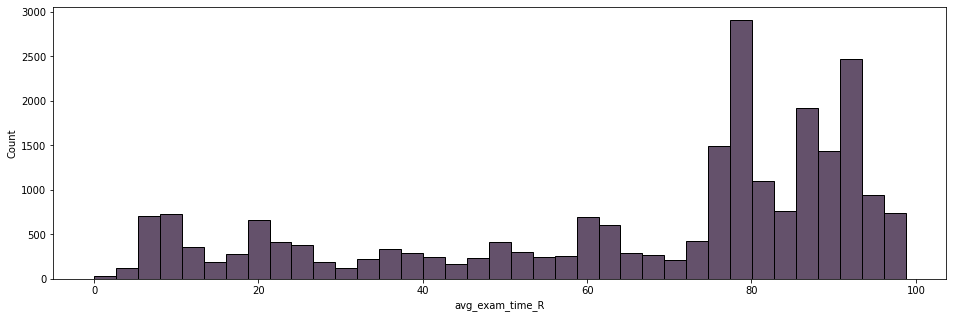

In [80]:
avg_exam_time = student_courses \
    .query('~is_banked') \
    .groupby('id_student', as_index=False) \
    .agg({'share': 'mean'}) \
    .rename(columns={'share': 'avg_exam_time_R'})

# Посмотрим на распределение
plt.figure(figsize=(16, 5))
sns.histplot(data=avg_exam_time.query('avg_exam_time_R <= 100'), x='avg_exam_time_R')
plt.show()

### <font color='#971c5b'> Завершаемость курсов </font>
Под завершаемостью курсов будем считать отношение кол-ва успешно сданных курсов, ко всем попыткам сдачи курсов

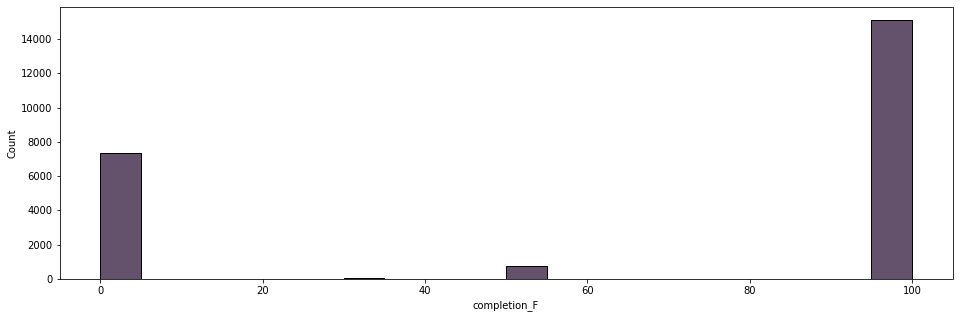

In [81]:
completion = student_courses \
    .query('~is_banked') \
    .groupby('id_student', as_index=False) \
    .agg({'is_pass': 'sum',
          'is_attempt': 'count'}) \
    .sort_values('is_attempt')

completion['completion_F'] = round(completion.is_pass / completion.is_attempt * 100)
completion = completion[['id_student', 'completion_F']]

# Посмотрим на распределение
plt.figure(figsize=(16, 5))
sns.histplot(data=completion, x='completion_F', bins=20)
plt.show()

### <font color='#971c5b'> Среднее количество баллов </font>

Под средним количеством баллов будем считать среднее количество баллов, которое идет в зачет, по всем сдаваемым курсам

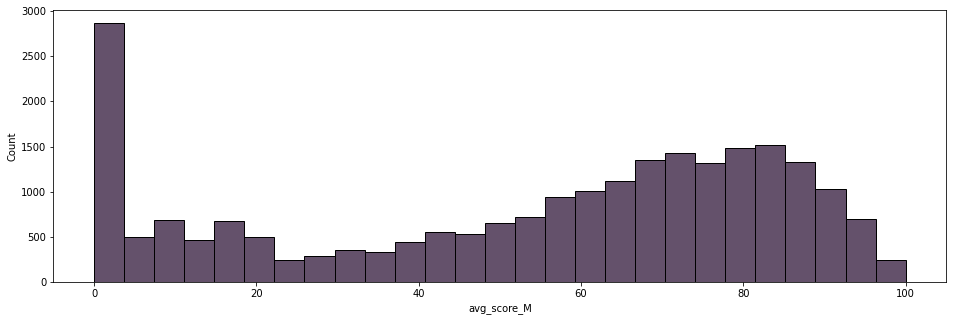

In [82]:
avg_score = student_courses \
    .query('~is_banked') \
    .groupby('id_student', as_index=False) \
    .agg({'course_score': 'mean'}) \
    .rename(columns={'course_score': 'avg_score_M'})

# Для студентов, которые не сдавали экзамен по курсам CCC и DDD поставим оценку за курс 0
avg_score.fillna(0, inplace=True)

# Посмотрим на распределение
plt.figure(figsize=(16, 5))
sns.histplot(data=avg_score, x='avg_score_M')
plt.show()

### <font color='#971c5b'> Выделение кластеров </font>

In [83]:
RFM = avg_exam_time \
    .merge(completion, on='id_student', how='outer') \
    .merge(avg_score, on='id_student', how='outer')
RFM.head()

,id_student,avg_exam_time_R,completion_F,avg_score_M
0,6516,78.07,100.0,63.50
1,8462,32.57,0.0,0.00
2,11391,79.10,100.0,82.40
3,23629,39.58,0.0,16.69
4,23698,90.33,100.0,80.00


Т.к. в завершаемости курса (**completion**) всего 5 уникальных значений, то и кластеры по ним прийдется вытсавлять вручную.

* 3 - 0 %
* 2 - (0; 99] %
* 1 - (99; 100] %


Для среднего времени сдачи (**avg_exam_time**) посчитаем кластеры по квантилям. 


Для средней оценки (**avg_score**) выделим отльный кластер **< 40** (те, кто не сдал курс) и остальных разделим на 4 кластера по квантилям

In [84]:
a = np.array([20, 30, 40])
np.concatenate((a, [1, 2]), axis=0)

array([20, 30, 40,  1,  2])

In [85]:
# Зададим границы
border_R = np.concatenate(((np.quantile(RFM.avg_exam_time_R, [.2, .4, .6, .8]) / 10).round() * 10, 
                           [RFM.avg_exam_time_R.max()]), 
                          axis=0)
print('R', border_R)

border_F = np.array([0, 99, 100])
print('F', border_F)

border_M = np.concatenate(([40], 
                           np.quantile(RFM.query('avg_score_M >= 40').avg_score_M, [.25, .5, .75, 1.]).round()), 
                          axis=0)
print('M', border_M)

R [ 40.   70.   80.   90.  247.5]
F [  0  99 100]
M [ 40.  61.  73.  83. 100.]


In [86]:
# Определим сегмент
    
RFM['R'] = RFM \
    .avg_exam_time_R \
    .apply(lambda x: str(list(x <= border_R).index(True) + 1))

RFM['F'] = RFM \
    .completion_F \
    .apply(lambda x: str(3 - list(x <= border_F).index(True)))


RFM['M'] = RFM \
    .avg_score_M \
    .apply(lambda x: str(5 - list(x <= border_M).index(True)))

RFM['RFM_score'] = RFM.R + RFM.F + RFM.M
RFM.sort_values('RFM_score', inplace=True)

#### Посмотрим на распределение полученных 

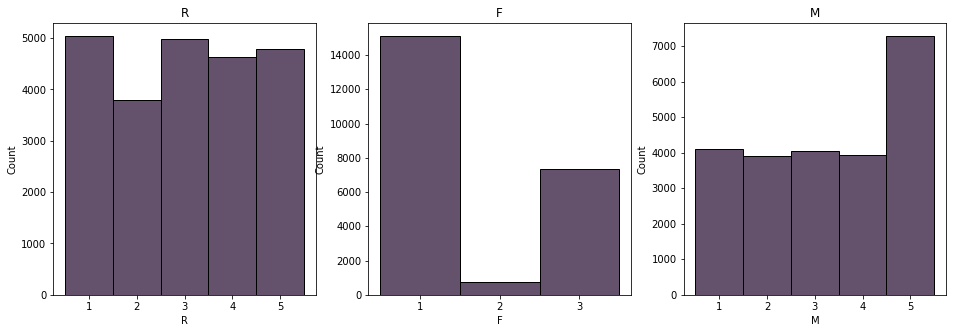

In [87]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

value = ['R', 'F', 'M']
for val, ax in zip(value, axes.flat):
    sns.histplot(data=RFM.sort_values(val), x=val, ax=ax)
    ax.set_title(val)
plt.show()

#### Посмотрим на распределение RM кластеров

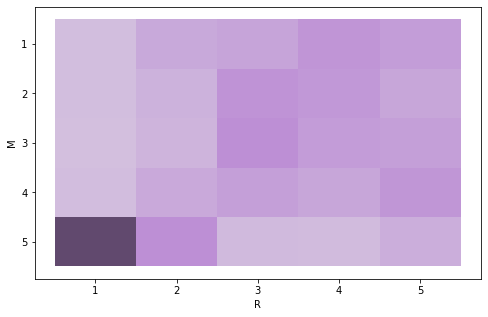

In [88]:
plt.figure(figsize=(8, 5))
sns.histplot(data=RFM.sort_values(['R', 'M']), x='R', y='M')
plt.show()

Видим, что очень много зарегистрировавшихся заканчивает курс еще до того, как прошло 40% от его длительности.

#### Посмотрим на распределение полученных сегментов без учета avg_exam_time > 100 (для наглядности)

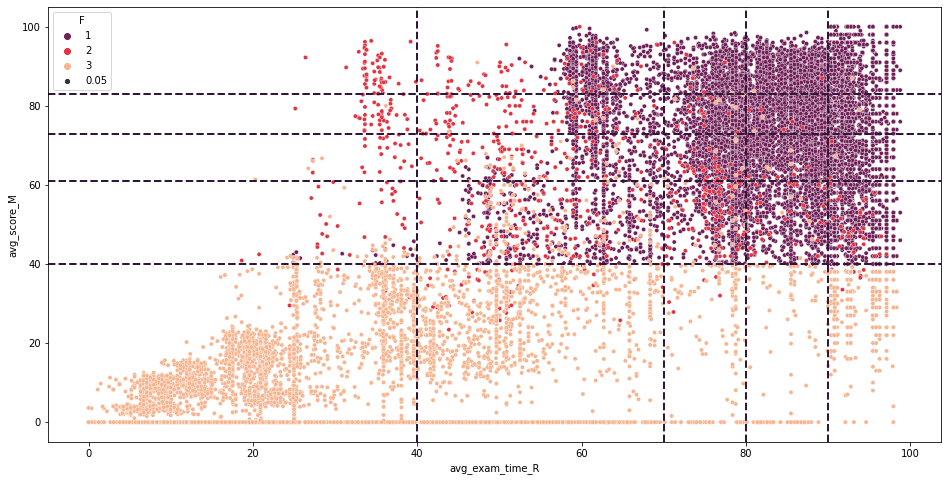

In [89]:
plt.figure(figsize=(16, 8))
RFM.sort_values('F', inplace=True)
sns.scatterplot(data=RFM.query('avg_exam_time_R <= 100'), 
                x='avg_exam_time_R', 
                y='avg_score_M', 
                hue='F', 
                palette=my_pallet[1::2],
                size=.05)

[plt.axvline(x=i, ls='--', linewidth=2) for i in border_R[:-1]]
[plt.axhline(y=i, ls='--', linewidth=2) for i in border_M[:-1]]
plt.show()

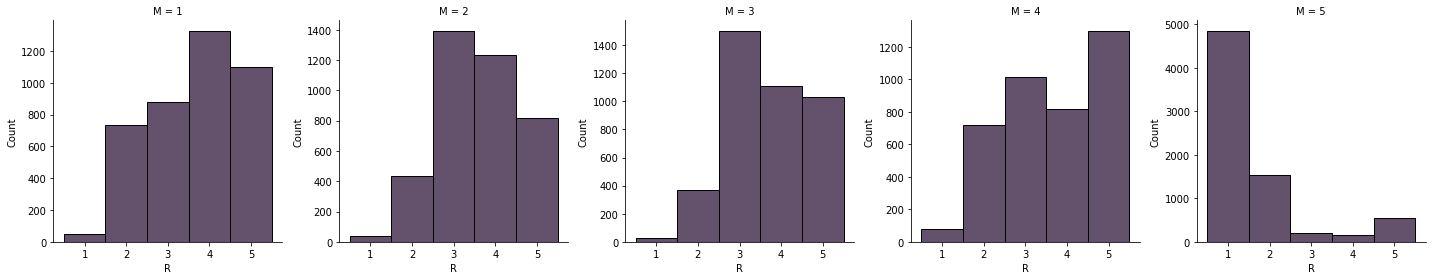

In [90]:
RFM.sort_values(['M', 'R'], inplace=True)
g = sns.FacetGrid(RFM, 
                  col="M",
                  sharey=False, 
                  height=4)

g = (g.map(sns.histplot, "R"))

Опираясь на графики и рассуждения, выделим основные группы за которыми хотелось бы следить.

Выдели следующие группы:

|Группа |Описание|Код|
|:---------------|:---------------------------------------------------------------------|:-----|
|**Сдающиеся быстро**|По всем курсам, на которые зарегистрировались, бросили занятия до того, как прошло 40% курса. <br>**Заканчивают до того как прошло 40% курса<br>Не завершили ни одного курса**|13[1-5]|
|**Сдающиеся в процессе**|Бросили все начатые курсы, но прошли по ним в сренем более 40% и не набрали по ним проходных баллов.<br>**Заканчивают после 40% курса<br>Не завершили ни одного курса**|[2-5]35|
|**Зря сдавшиеся**|Бросают занятия, но при этом набирают достаточное количество баллов для зачета. Им необходима дополнительная мотивация/поощрения чтоб остаться, т.к. их баллы говорят, что они способны завершить курс.<br>**Оценка больше 40%<br>Не завершили ни одного курса**|[2-5]3[1-4]|
|**Слабосдающие в семестре**|Троечники, которые в среднем сдают курс до его окончания. Слишком спешат со сдачей, они могут сдавать позже и лучше освоить материал.<br>**Заканчивают до 80% курса<br>Средняя оценка до 61 баллов**|[1-3][1-2][4-5]|
|**Хорошосдающие в семестре**|Хорошисты, которые в среднем сдают курс до его окончания. Слишком спешат со сдачей, они могут сдавать позже и лучше освоить материал либо взять дополнительный предмет, т.к. они в целом быстрее осваивают материал.<br>**Заканчивают до 80% курса<br>Средняя оценка 61-83 балла**|[1-3][1-2][2-3]|
|**Отличносдающие в семестре**|Отличники. Самые сильные студенты, сдают рано и с высокими баллами. Им можно предлагать дополнительные курсы, т.к. до конца семестра остается время.<br>**Заканчивают до 80% курса<br>Средняя оценка от 83 баллов**|[1-3][1-2]1|
|**Слабосдающие в конце**|Троечники сдающие в конце. Этим студентам однозначно надо прикладывать большее усилий вначале/середине семестра. Либо брать курсы попроще.<br>**Заканчивают 80-90% курса<br>Средняя оценка до 61 баллов**|4[1-2][4-5]|
|**Затягивающие троечники**|Из всех, кто получает зачет это самая слабая категория. Т.к. сдают семестр только в самом конце. Скорее всего им подойдут более легкие курсы.<br>**Заканчивают после 90% курса<br>Средняя оценка до 61 баллов**|5[1-2][4-5]|
|**Хорошисты сдающие во второй половине**|Хорошисты, но сдают в конце семестра, скорее всего взяли курсы, которые зачитываются по экзамену либо сильно затягивают. Если затягивают, то им стоит сделать больший упор в середине семестра, чтоб показать лучший регультат.<br>**Заканчивают после 90% курса<br>Средняя оценка 61-83 балла**|[4-5][1-2][2-3]|
|**Отличники сдающие во второй половине**|Отличники, но сдают в самом конце семестра, скорее всего взяли курсы, которые зачитываются по экзамену.<br>**Заканчивают после 80% курса<br>Средняя оценка от 83 баллов**|5[1-2]1|

In [91]:
segt_map = {
    r'[4-5][1-2]1': 'Отличники сдающие во второй половине',
    r'[4-5][1-2][2-3]': 'Хорошисты сдающие во второй половине',
    r'5[1-2][4-5]': 'Затягивающие троечники',
    r'4[1-2][2-3]': 'Хорошосдающие в конце',
    r'4[1-2][4-5]': 'Слабосдающие в конце',
    r'[1-3][1-2]1': 'Отличносдающие в семестре',
    r'[1-3][1-2][2-3]': 'Хорошосдающие в семестре',
    r'[1-3][1-2][4-5]': 'Слабосдающие в семестре',
    r'[2-5]3[1-4]': 'Зря сдавшиеся',
    r'[2-5]35': 'Сдающиеся в процессе',
    r'13[1-5]': 'Сдающиеся быстро'
}

RFM['Segment'] = RFM['RFM_score'].replace(segt_map, regex=True)
RFM.Segment.value_counts()

Сдающиеся быстро                        4874
Хорошисты сдающие во второй половине    4172
Хорошосдающие в семестре                3721
Отличники сдающие во второй половине    2422
Сдающиеся в процессе                    2289
Слабосдающие в семестре                 1715
Отличносдающие в семестре               1663
Затягивающие троечники                  1381
Слабосдающие в конце                     813
Зря сдавшиеся                            197
Name: Segment, dtype: int64

### Посмотрим, какие курсы выбирают разные группы.

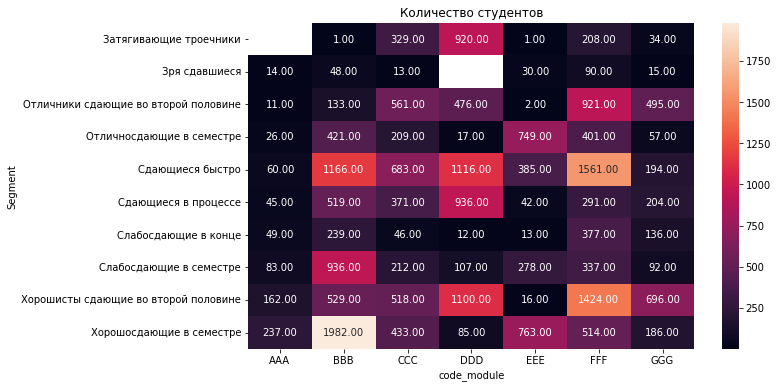

In [92]:
segment_module = student_courses \
    .query('~is_banked')[['id_student', 'code_module', 'course_score', 'share']] \
    .drop_duplicates() \
    .merge(RFM, 
           on='id_student', 
           how='left')[['id_student', 'code_module', 'Segment', 'course_score', 'share']] \
    .groupby(['code_module', 'Segment'], as_index=False) \
    .agg({'id_student': 'count',
          'course_score': 'mean',
          'share': 'mean'}) \
    .rename(columns={'id_student': 'num_reg'})

plt.figure(figsize=(10, 6))
module = segment_module.pivot('Segment', 'code_module', 'num_reg')
sns.heatmap(module, annot=True, fmt=".2f")
plt.title('Количество студентов')
plt.show()

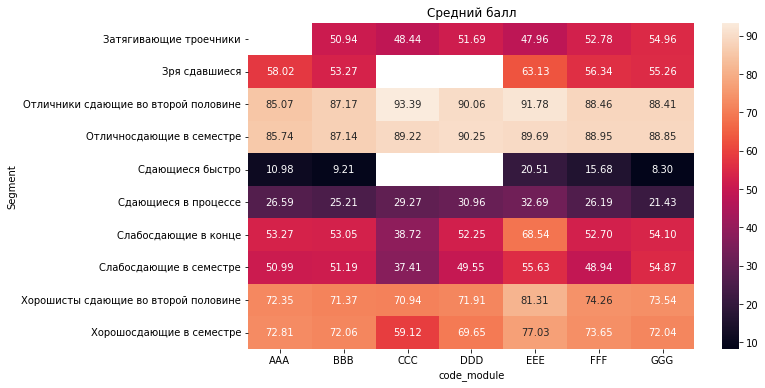

In [93]:
plt.figure(figsize=(10, 6))
module = segment_module.pivot('Segment', 'code_module', 'course_score')
sns.heatmap(module, annot=True, fmt=".2f")
plt.title('Средний балл')
plt.show()

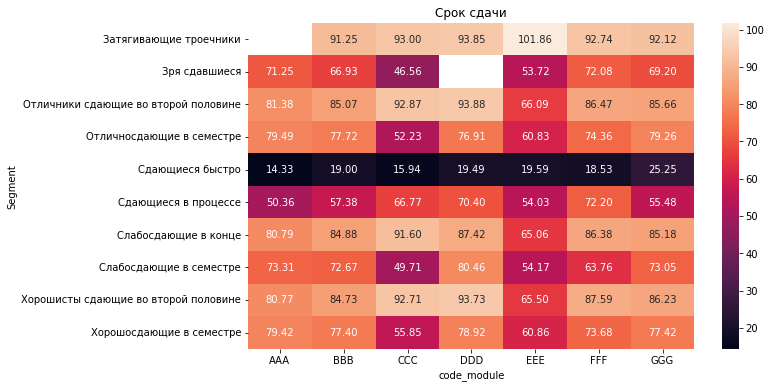

In [94]:
plt.figure(figsize=(10, 6))
module = segment_module.pivot('Segment', 'code_module', 'share')
sns.heatmap(module, annot=True, fmt=".2f")
plt.title('Срок сдачи')
plt.show()

|Группа |Краткий вывод|
|:---------------|:----|
|**Сдающиеся быстро**| Видим, что эти студенты все же начинают что-то сдавать, но теряют мотивацию. По курсам FFF, BBB, DDD и CCC стоит выяснить причину, т.к. таких студентов довольно много. Скорее всего курсы довольно сложные, этот же вывод следует из задания 2. Таким студентам надо советовать курсы попроще, либо создать доп. курсы для слабых студентов.|
|**Сдающиеся в процессе**| Видим, что этим студентам даже простые модули даются трудно. Слабая группа студентов.|
|**Зря сдавшиеся**|Студенты, которые отменяли регистрацию, при этом в семестре набирали достаточное количество баллов для зачета. Вот эти студенты скорее всего теряли интерес к предмету, либо не поняли систему оценок. С ними можно провести опрос, чтоб понять чем вызвана их мотивация завершить курс.|
|**Слабосдающие в семестре**| Им стоит не спешить со сдачей курса и понять материал получше. Даже в молдуле с поздним сроком сдачи (CCC) они сдают слишком рано. По остальным модулям набрав достаточное количество баллов перестают сдавать тесты. Что говорит о том, что они учатся не ради знаний, а ради зачета.|
|**Хорошосдающие в семестре**| Хорошо учатся, но явно могли бы учиться еще лучше. Особенно по модулю CCC слишком спешат сдать экзамен. Таким студентам можно предложить приложить больше усилий и не спешить завершать курс. Либо предложить дополнительный курс, который будет попроще.|
|**Отличносдающие в семестре**|Ожидалось, что эти студенты сдают только модули, где экзамен засчитывается на основании тестов, но как показывает график выше, они также отлично сдают экзамены(CCC, DDD) в первых 80%. С такой успеваемостью, они точно могли бы взять дополнительный предмет, особенно если он сдается в конце семестра (Из задания 3). Либо эти студенты могут курировать более слабых, что улучшит лояльность слабых и даст отличникам дополнительный навык.|
|**Слабосдающие в конце**|Видим, что эти студенты выбирают в большей степени не самые легкие курсы (следует из задания 2). Им надо прикладывать больше усилий, или правда брать курсы попроще (AAA, DDD, EEE, GGG).|
|**Затягивающие троечники**| Видим, что самый простой модуль (ААА) такие студенты совсем не выбирают. Им стоит либо вначале/середине семестра прикладывать больше усилий, задавать больше вопросов. Либо выбирать курсы проще.|
|**Хорошисты сдающие во второй половине**| Видим, что эти студенты в основном сдают сложные модули, что с их успеваемостью даже хорошо. Учитывая, что модули довольно трудные и они с ними справляются, этих студентов можно отметить как сильных. |
|**Отличники сдающие во второй половине**| Тоже самые сильные студенты, причина их долгой сдачи - курсы, которые сдаются под конец. (Видно из задания 3). Этим студентам можно дополнительно взять модули, которые попроще, либо модули у которых есть возможность сдать его раньше (EEE, BBB, AAA), чтоб их экзамены не пересекались и не было слишком большой нагрузки.|

[<font size = 1> <div style="text-align: right"> [К навигации] </div>  </font>](#0-bullet)

***